<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

In [ ]:
!nvidia-smi

Sun Mar 20 17:18:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install TensorFlow and TensorFlow Model Garden

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.8.0


In [ ]:
!pip install -q tensorflow==2.3.0

     |████████████████████████████████| 320.4 MB 53 kB/s 
     |████████████████████████████████| 2.9 MB 39.4 MB/s 
     |████████████████████████████████| 20.1 MB 46.5 MB/s 
     |████████████████████████████████| 459 kB 42.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.7.0 requires numpy>=1.19.0, but you have numpy 1.18.5 which is incompatible.
jaxlib 0.3.0+cuda11.cudnn805 requires numpy>=1.19, but you have numpy 1.18.5 which is incompatible.
jax 0.3.1 requires numpy>=1.19, but you have numpy 1.18.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 506), reused 1388 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 25.31 MiB/s, done.
Resolving deltas: 100% (506/506), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

     |████████████████████████████████| 8.3 MB 11.5 MB/s 
     |████████████████████████████████| 206 kB 48.6 MB/s 
     |████████████████████████████████| 15.7 MB 33.6 MB/s 
     |████████████████████████████████| 280 kB 39.7 MB/s 
     |████████████████████████████████| 99 kB 7.6 MB/s 
     |████████████████████████████████| 38.1 MB 37.2 MB/s 
     |████████████████████████████████| 237 kB 35.6 MB/s 
     |████████████████████████████████| 4.2 MB 34.4 MB/s 
     |████████████████████████████████| 1.1 MB 33.7 MB/s 
     |████████████████████████████████| 352 kB 39.8 MB/s 
     |████████████████████████████████| 1.2 MB 17.2 MB/s 
     |████████████████████████████████| 11.2 MB 16.5 MB/s 
     |████████████████████████████████| 47.8 MB 39 kB/s 
     |████████████████████████████████| 596 kB 23.2 MB/s 
     |████████████████████████████████| 4.3 MB 35.6 MB/s 
     |████████████████████████████████| 114 kB 41.4 MB/s 
     |████████████████████████████████| 46 kB 1.6 MB/s 
     |██████████

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
import numpy as np
import pandas as pd


df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip', compression = 'zip', low_memory =False )

In [ ]:
df.shape

(1306122, 3)

In [ ]:
df.head(20)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


Create tf.data.Datasets for Training and Evaluation

In [ ]:
from sklearn.model_selection import train_test_split
train_df, remain = train_test_split(df,random_state= 42, train_size=0.0075, stratify=df.target.values)
valid_df, _ = train_test_split(remain, random_state = 42, train_size = 0.00075,stratify=remain.target.values)
train_df.shape, valid_df.shape

((9795, 3), (972, 3))

In [ ]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.question_text.values,valid_df.target.values))
  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


## Task 5: Download a Pre-trained BERT Model from TensorFlow Hub

In [ ]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""
label_list = [0,1]
max_seq_length = 50
train_batch_size = 30
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()


do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file,do_lower_case)

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2



In [ ]:
tokenizer.wordpiece_tokenizer.tokenize("hi hu hu hu?")

['hi', 'hu', 'hu', 'hu', '##?']

In [ ]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize("hi hu hu hu?"))

[7632, 15876, 15876, 15876, 29632]

## Task 6: Tokenize and Preprocess Text for BERT

In [ ]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid= None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0,example,label_list,max_seq_length,tokenizer)
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id) 
  

In [ ]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp = [text,label], 
                                                                Tout =[tf.int32,tf.int32,tf.int32,tf.int32])
  
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])
  
  x= {
      'input_word_ids': input_ids,
      'input_mask': input_mask,
      'input_type_ids': segment_ids
  }
  return (x,label_id)

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls= tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32,drop_remainder = True)
  .prefetch(tf.data.experimental.AUTOTUNE))
  #valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls= tf.data.experimental.AUTOTUNE)
  .batch(32,drop_remainder = True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  
  

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [ ]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 50), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 50), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 50), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 50), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 50), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 50), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [ ]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")
  
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])


  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1,activation='sigmoid',name = "output")(drop)
  model = tf.keras.Model(
      inputs = {
          'input_word_ids': input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs=output
  )
  return model

In [ ]:
model = create_model()
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 2e-5),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics= [tf.keras.metrics.BinaryAccuracy()]
)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 50, 768)]                 'input_mask[0][0]',       

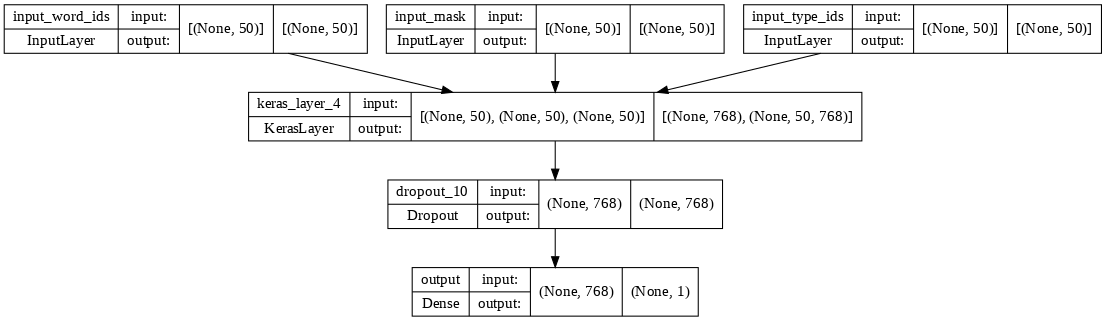

In [ ]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi =76)

In [ ]:
# Train model
epochs = 4 
history = model.fit(
    train_data,
    validation_data = valid_data,
    epochs = epochs,
    verbose = 1
)

Epoch 1/4
306/306 [==============================] - 227s 680ms/step - loss: 0.1701 - binary_accuracy: 0.9392 - val_loss: 0.1243 - val_binary_accuracy: 0.9594
Epoch 2/4
306/306 [==============================] - 205s 665ms/step - loss: 0.0967 - binary_accuracy: 0.9632 - val_loss: 0.1449 - val_binary_accuracy: 0.9469
Epoch 3/4
306/306 [==============================] - 207s 674ms/step - loss: 0.0498 - binary_accuracy: 0.9819 - val_loss: 0.1771 - val_binary_accuracy: 0.9531
Epoch 4/4
306/306 [==============================] - 206s 670ms/step - loss: 0.0241 - binary_accuracy: 0.9913 - val_loss: 0.2204 - val_binary_accuracy: 0.9490


## Task 11: Evaluate the BERT Text Classification Model

In [ ]:
!pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 10.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  

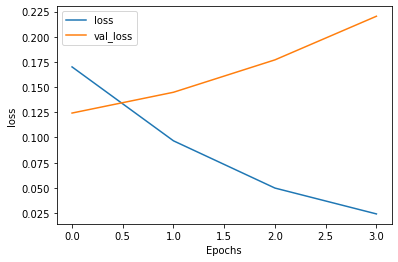

In [ ]:
plot_graphs(history,'loss')

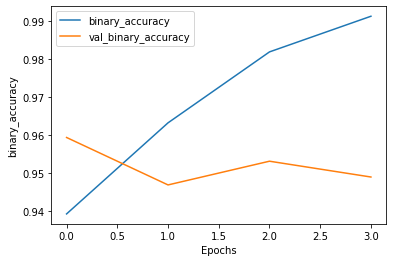

In [ ]:
plot_graphs(history,'binary_accuracy')

In [ ]:
a = []
test_ = tf.data.Dataset.from_tensor_slices((a), [0]*len(a))
test_ = (test_.map(to_feature_map).batch(1))
preds = model.predict(test_)
threshold = 0.6 
['Warning' if pred >= threshold else 'Pass' for pred in preds]

TypeError: ignored